# Classification example with Pytorch-Lightning

A short example with a classic classification originated from [the official documentation](https://pytorch-lightning.readthedocs.io/en/latest/notebooks/lightning_examples/mnist-hello-world.html).

The example trains a classifier, learning how to classify the digits in MNIST.

In [3]:
import os

import pandas as pd
import seaborn as sn
import torch
from IPython.display import display
# from IPython.core.display import display ## deprecated, altered with "from IPython.display"
from pytorch_lightning import LightningModule, Trainer
from pytorch_lightning.callbacks.progress import TQDMProgressBar
from pytorch_lightning.loggers import CSVLogger
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, random_split
from torchmetrics import Accuracy
from torchvision import transforms
from torchvision.datasets import MNIST

PATH_DATASETS = os.environ.get("PATH_DATASETS", ".")
BATCH_SIZE = 256 if torch.cuda.is_available() else 64

## The Simplest Example

In [4]:
class MNISTModel(LightningModule):
    def __init__(self):
        super().__init__()
        self.l1 = torch.nn.Linear(28 * 28, 10)

    def forward(self, x):
        return torch.relu(self.l1(x.view(x.size(0), -1)))

    def training_step(self, batch, batch_nb):
        x, y = batch
        loss = F.cross_entropy(self(x), y)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.02)

In [5]:
# Init our model
mnist_model = MNISTModel()

# Init DataLoader from MNIST Dataset
dataset = MNIST(PATH_DATASETS, train=True, download=True, transform=transforms.ToTensor())

train, val, unused = random_split(dataset, [5000, 5000, 50000]) # dataset splitted to have only 5000 samples for performance measure.
train_loader = DataLoader(train, batch_size=BATCH_SIZE)

# Initialize a trainer
trainer = Trainer(
    accelerator="auto",
    devices=1 if torch.cuda.is_available() else None,  # limiting got iPython runs
    max_epochs=3,
    callbacks=[TQDMProgressBar(refresh_rate=20)],
)

# Train the model ⚡
trainer.fit(mnist_model, train_loader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name | Type   | Params
--------------------------------
0 | l1   | Linear | 7.9 K 
--------------------------------
7.9 K     Trainable params
0         Non-trainable params
7.9 K     Total params
0.031     Total estimated model params size (MB)
/Users/jlee/Documents/22.2H/pytorch-lightning-practice/venv/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

## Slightly more features.

The model below has validation_steps, test_steps and data preparing hooks for more features supported.

In [7]:
class LitMNIST(LightningModule):
    def __init__(self, data_dir=PATH_DATASETS, hidden_size=64, learning_rate=2e-4):

        super().__init__()

        # Set our init args as class attributes
        self.data_dir = data_dir
        self.hidden_size = hidden_size
        self.learning_rate = learning_rate

        # Hardcode some dataset specific attributes
        self.num_classes = 10
        self.dims = (1, 28, 28)
        channels, width, height = self.dims
        self.transform = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize((0.1307,), (0.3081,)),
            ]
        )

        # Define PyTorch model
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(channels * width * height, hidden_size),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_size, self.num_classes),
        )

        self.val_accuracy = Accuracy()
        self.test_accuracy = Accuracy()

    def forward(self, x):
        x = self.model(x)
        return F.log_softmax(x, dim=1)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.nll_loss(logits, y)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.nll_loss(logits, y)
        preds = torch.argmax(logits, dim=1)
        self.val_accuracy.update(preds, y)

        # Calling self.log will surface up scalars for you in TensorBoard
        self.log("val_loss", loss, prog_bar=True)
        self.log("val_acc", self.val_accuracy, prog_bar=True)

    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.nll_loss(logits, y)
        preds = torch.argmax(logits, dim=1)
        self.test_accuracy.update(preds, y)

        # Calling self.log will surface up scalars for you in TensorBoard
        self.log("test_loss", loss, prog_bar=True)
        self.log("test_acc", self.test_accuracy, prog_bar=True)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer

    ####################
    # DATA RELATED HOOKS
    ####################

    def prepare_data(self):
        # download
        MNIST(self.data_dir, train=True, download=True)
        MNIST(self.data_dir, train=False, download=True)

    def setup(self, stage=None):

        # Assign train/val datasets for use in dataloaders
        mnist_full = MNIST(self.data_dir, train=True, transform=self.transform)

        # only 5000 samples used for training, testing and validation for performance measure
        self.mnist_train, self.mnist_val, self.mnist_test, _ = random_split(mnist_full, [5000, 5000, 5000, 45000])

        ######### below is the original sample code in case if you want the full fledged training ########
        # if stage == "fit" or stage is None:
        #     mnist_full = MNIST(self.data_dir, train=True, transform=self.transform)
        #     self.mnist_train, self.mnist_val = random_split(mnist_full, [55000, 5000])

        # # Assign test dataset for use in dataloader(s)
        # if stage == "test" or stage is None:
        #     self.mnist_test = MNIST(self.data_dir, train=False, transform=self.transform)

    def train_dataloader(self):
        return DataLoader(self.mnist_train, batch_size=BATCH_SIZE)

    def val_dataloader(self):
        return DataLoader(self.mnist_val, batch_size=BATCH_SIZE)

    def test_dataloader(self):
        return DataLoader(self.mnist_test, batch_size=BATCH_SIZE)

In [8]:
model = LitMNIST()
trainer = Trainer(
    accelerator="auto",
    devices=1 if torch.cuda.is_available() else None,  # limiting got iPython runs
    max_epochs=3,
    callbacks=[TQDMProgressBar(refresh_rate=20)],
    logger=CSVLogger(save_dir="logs/"),
)
trainer.fit(model)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: logs/lightning_logs

  | Name          | Type       | Params
---------------------------------------------
0 | model         | Sequential | 55.1 K
1 | val_accuracy  | Accuracy   | 0     
2 | test_accuracy | Accuracy   | 0     
---------------------------------------------
55.1 K    Trainable params
0         Non-trainable params
55.1 K    Total params
0.220     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/Users/jlee/Documents/22.2H/pytorch-lightning-practice/venv/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

### Testing

Testing can be done with one-liner code.

In [9]:
trainer.test()

/Users/jlee/Documents/22.2H/pytorch-lightning-practice/venv/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:1446: UserWarning: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `test(ckpt_path='best')` to use and best model checkpoint and avoid this warning or `ckpt_path=trainer.checkpoint_callback.last_model_path` to use the last model.
  rank_zero_warn(
Restoring states from the checkpoint path at logs/lightning_logs/version_0/checkpoints/epoch=2-step=237.ckpt
Loaded model weights from checkpoint at logs/lightning_logs/version_0/checkpoints/epoch=2-step=237.ckpt
/Users/jlee/Documents/22.2H/pytorch-lightning-practice/venv/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the nu

Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc             0.866599977016449
        test_loss           0.5190314650535583
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.5190314650535583, 'test_acc': 0.866599977016449}]

## Display results.

Note that we are only training very small amount of unbalanced samples in this example.

,val_loss,val_acc,test_loss,test_acc
epoch,,,,
0,1.349962,0.6766,NaN,NaN
1,0.704383,0.8254,NaN,NaN
2,0.527099,0.8586,NaN,NaN
2,NaN,NaN,0.519031,0.8666


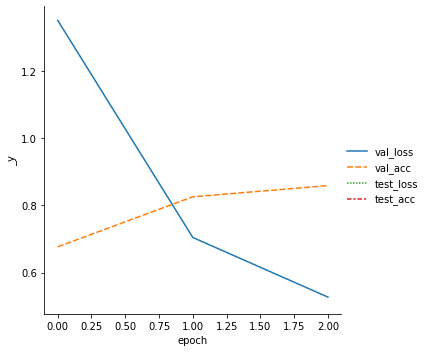

In [10]:
metrics = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")
del metrics["step"]
metrics.set_index("epoch", inplace=True)
display(metrics.dropna(axis=1, how="all").head())
sn.relplot(data=metrics, kind="line")